# PCA
- Principal Component Analysis (PCA) is a procedure that converts a set of observations from m to n dimensions (m > n), after analyzing the correlated features of the variables. It is used to move the data from high to a low dimension for visualization or dimensionality reduction purposes.
### Applying PCA is no different than applying other estimators:
1. create an estimator,
2. fit it on the model to get a transformer,
3. apply the transformer to the data.

## PCA - Visualization
- Dataset of handwritten image has 785 columns. The first column represents a label defining the digit class (0 →9), the other 784 columns represent the pixel values of the 28*28 image.
- Use PCA to reduce the dimensions to only 2

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PCA_visual').getOrCreate()

In [ ]:
data = spark.read.csv('digits.csv', header=True, inferSchema=True)

In [ ]:
data.printSchema()

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# output: lable
# input: pixel0 => pixel783
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol='features')
data_2 = assembler.transform(data)

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=2, inputCol='features', outputCol='features_pca')

In [ ]:
pca_model = pca.fit(data_2)

In [ ]:
pca_model.explainedVariance
# from 784 dementions => 2 dementions: We keep only ~17% value of dataset
# we need more dementions than 2.

DenseVector([0.0975, 0.0716])

In [ ]:
pca_data = pca_model.transform(data_2).select('features_pca')

In [ ]:
pca_data.show(3, truncate=False)

+----------------------------------------+
|features_pca                            |
+----------------------------------------+
|[103.73881375798244,699.5124334036431]  |
|[2466.786278309411,360.7526613889307]   |
|[-121.55984060478046,293.96688737760746]|
+----------------------------------------+
only showing top 3 rows



In [ ]:
# Change data to df: with 3 columns: label, comp1, comp2
temp = pca_data.select("features_pca").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [ ]:
temp.show(5)

+-------------------+-------------------+
|                 _1|                 _2|
+-------------------+-------------------+
| 103.73881375798244|  699.5124334036431|
|  2466.786278309411|  360.7526613889307|
|-121.55984060478046| 293.96688737760746|
|  599.5789910719535|-299.98165533942404|
|  2689.044309475987|  449.3541744175658|
+-------------------+-------------------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as f

In [ ]:
data_label= data.select('label')
data_label = data_label.withColumn('row_index', f.monotonically_increasing_id())

temp=temp.withColumn('row_index', f.monotonically_increasing_id())

temp = temp.join(data_label, on=["row_index"]).sort("row_index").drop("row_index")

In [ ]:
temp.show(3)

+-------------------+------------------+-----+
|                 _1|                _2|label|
+-------------------+------------------+-----+
| 103.73881375798244| 699.5124334036431|    1|
|  2466.786278309411| 360.7526613889307|    0|
|-121.55984060478046|293.96688737760746|    1|
+-------------------+------------------+-----+
only showing top 3 rows



In [ ]:
temp = temp.select(f.col("_1").alias("comp1"), f.col("_2").alias("comp2"), "label")

In [ ]:
temp.show(3)

+-------------------+------------------+-----+
|              comp1|             comp2|label|
+-------------------+------------------+-----+
| 103.73881375798244| 699.5124334036431|    1|
|  2466.786278309411| 360.7526613889307|    0|
|-121.55984060478046|293.96688737760746|    1|
+-------------------+------------------+-----+
only showing top 3 rows



In [ ]:
df = temp.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

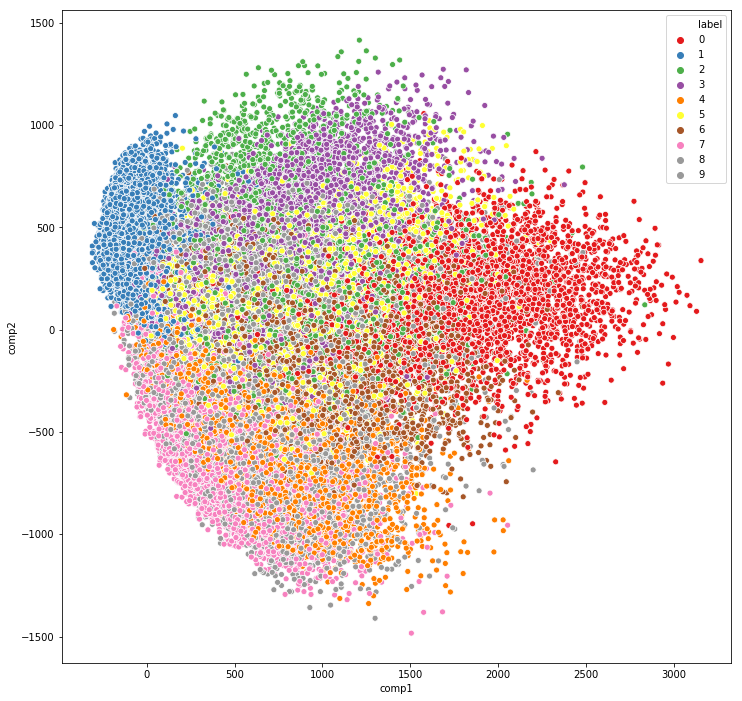

In [ ]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='comp1', y='comp2', hue='label', palette="Set1", legend='full')
plt.show()